In [29]:
import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))
sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *
from src.descriptive_analytics import *
from src.descriptive_analysis.time import *

from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql.types import NumericType, StringType
from pyspark.sql import functions as F

import seaborn as sns

import numpy as np

from itertools import combinations

from scipy import stats

import matplotlib.pyplot as plt

import pandas as pd



In [30]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")

## Decriptive Analysis

### Time Analysis 

In [38]:
# Extract time-based features
df = df.withColumn("Hour", F.hour("Start_Time"))
df = df.withColumn("DayOfWeek", F.dayofweek("Start_Time"))  # Sunday = 1
df = df.withColumn("Month", F.month("Start_Time"))
df = df.withColumn("Year", F.year("Start_Time"))

# Calculate duration in minutes
df = df.withColumn("Duration", (F.unix_timestamp("End_Time") - F.unix_timestamp("Start_Time")) / 60)

# Add Is_Weekend column: Saturday (7) or Sunday (1)
df = df.withColumn("Is_Weekend", F.when(F.col("DayOfWeek").isin(1, 7), 1).otherwise(0))

# Add Season column
df = df.withColumn(
    "Season",
    F.when(F.col("Month").isin(3, 4, 5), "Spring")
    .when(F.col("Month").isin(6, 7, 8), "Summer")
    .when(F.col("Month").isin(9, 10, 11), "Fall")
    .otherwise("Winter")  # December (12), January (1), February (2)
)

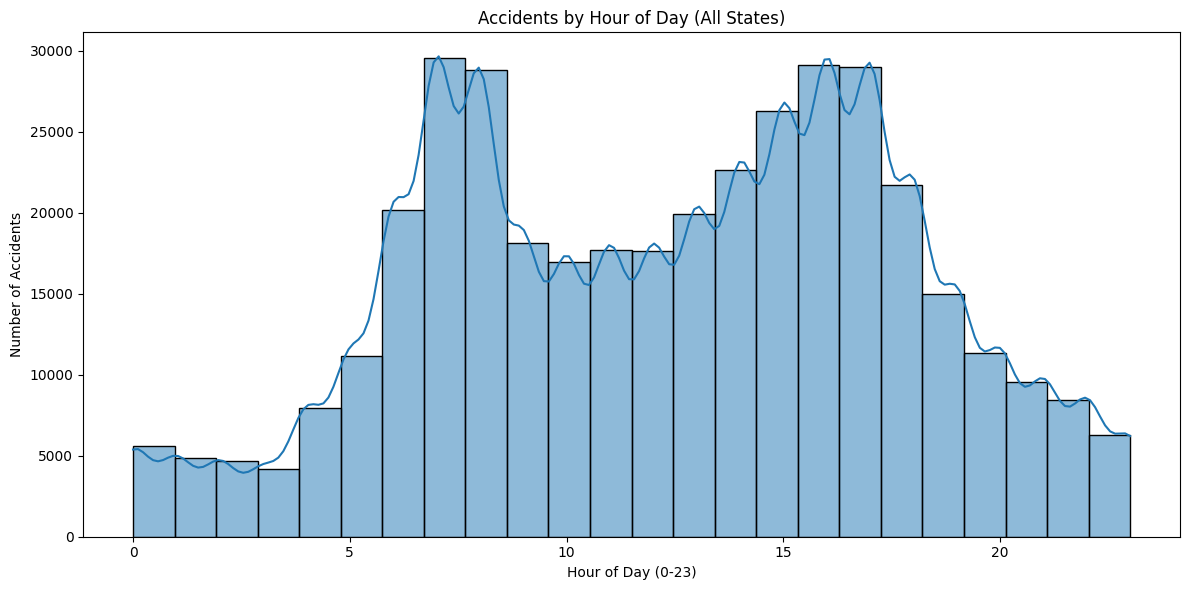

In [32]:
sample_fraction=0.05

sample_df = df.select("Hour").sample(fraction=sample_fraction).toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(sample_df['Hour'], bins=24, kde=True)
plt.title('Accidents by Hour of Day (All States)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

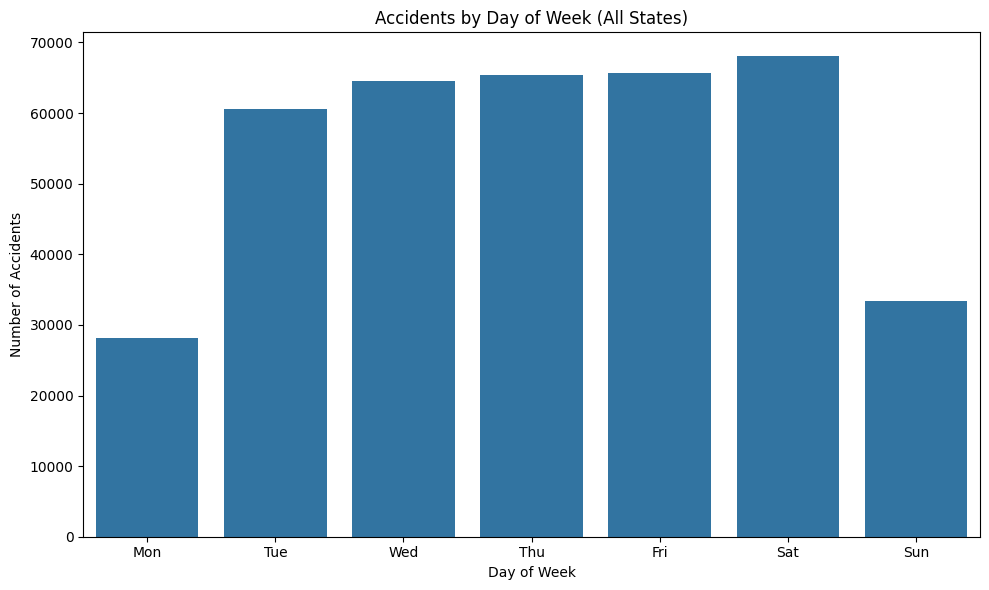

In [33]:
sample_df = df.select("DayOfWeek").sample(fraction=sample_fraction).toPandas()

plt.figure(figsize=(10, 6))
sns.countplot(x='DayOfWeek', data=sample_df)
plt.title('Accidents by Day of Week (All States)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.show()


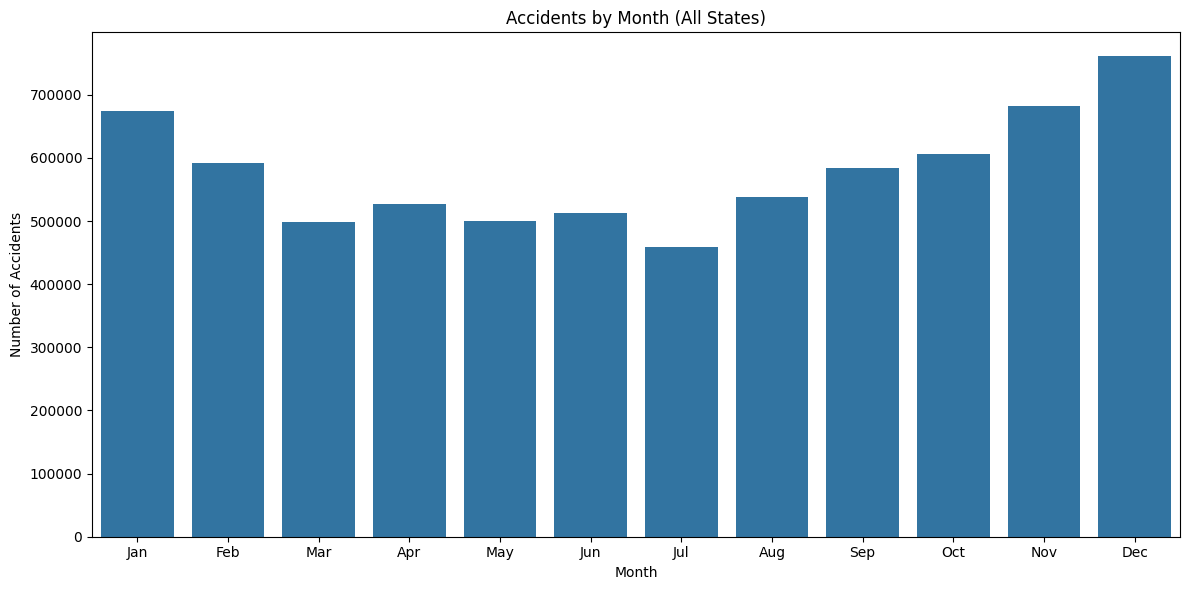

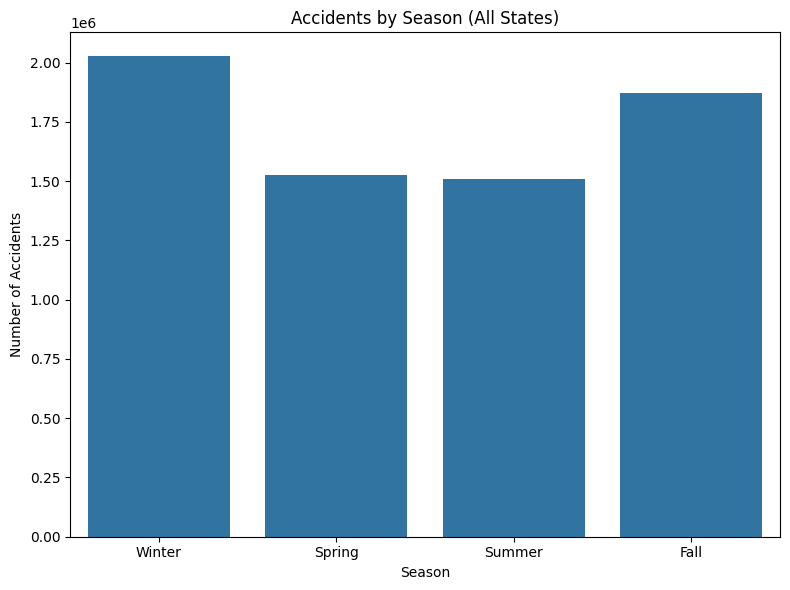

In [47]:
sample_df = df.select("Month", "Season").sample(fraction=0.9).toPandas()

# Plot 1: Accidents by Month
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', data=sample_df)
plt.title('Accidents by Month (All States)')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()


# Plot 2: Accidents by Season
plt.figure(figsize=(8, 6))
sns.countplot(x='Season', data=sample_df, order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('Accidents by Season (All States)')
plt.xlabel('Season')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

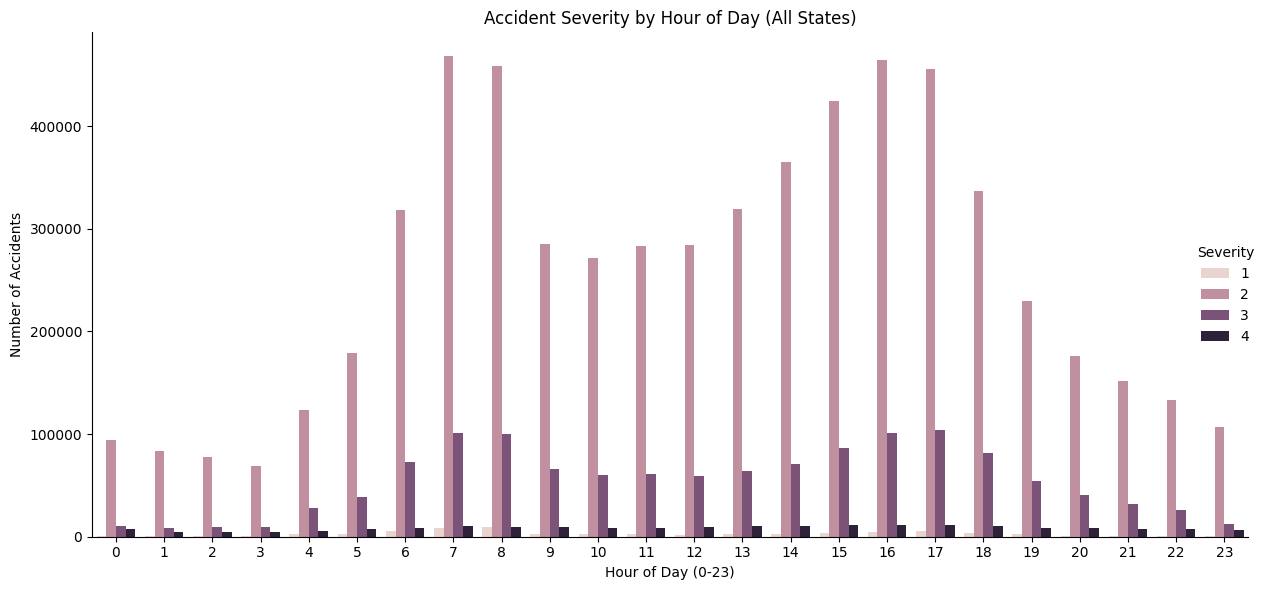

In [35]:
severity_hour = df.groupBy("Hour", "Severity").count().toPandas()

plt.figure(figsize=(12, 6))
sns.catplot(x="Hour", y="count", hue="Severity", kind="bar", data=severity_hour, height=6, aspect=2)
plt.title('Accident Severity by Hour of Day (All States)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()


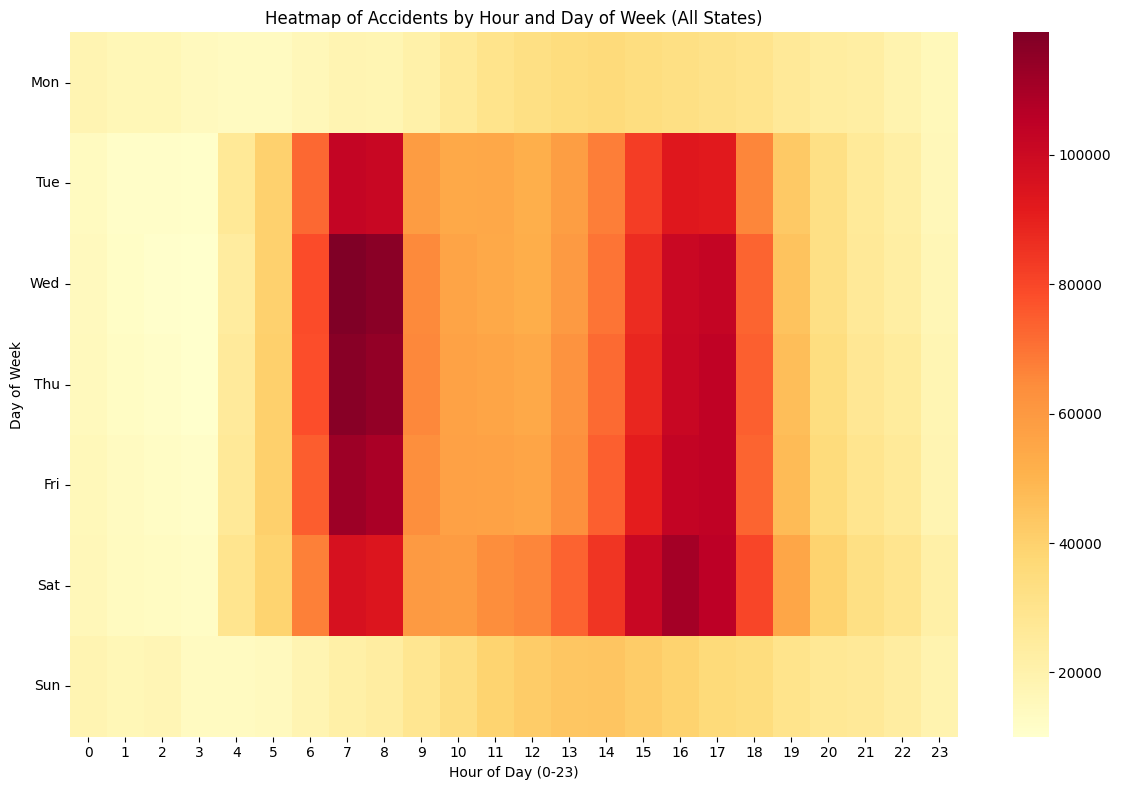

In [36]:
heat_df = df.groupBy("DayOfWeek", "Hour").count().toPandas()
heatmap_data = heat_df.pivot(index='DayOfWeek', columns='Hour', values='count').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd')
plt.title('Heatmap of Accidents by Hour and Day of Week (All States)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Day of Week')
plt.yticks(ticks=[0.5+i for i in range(7)], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.tight_layout()
plt.show()

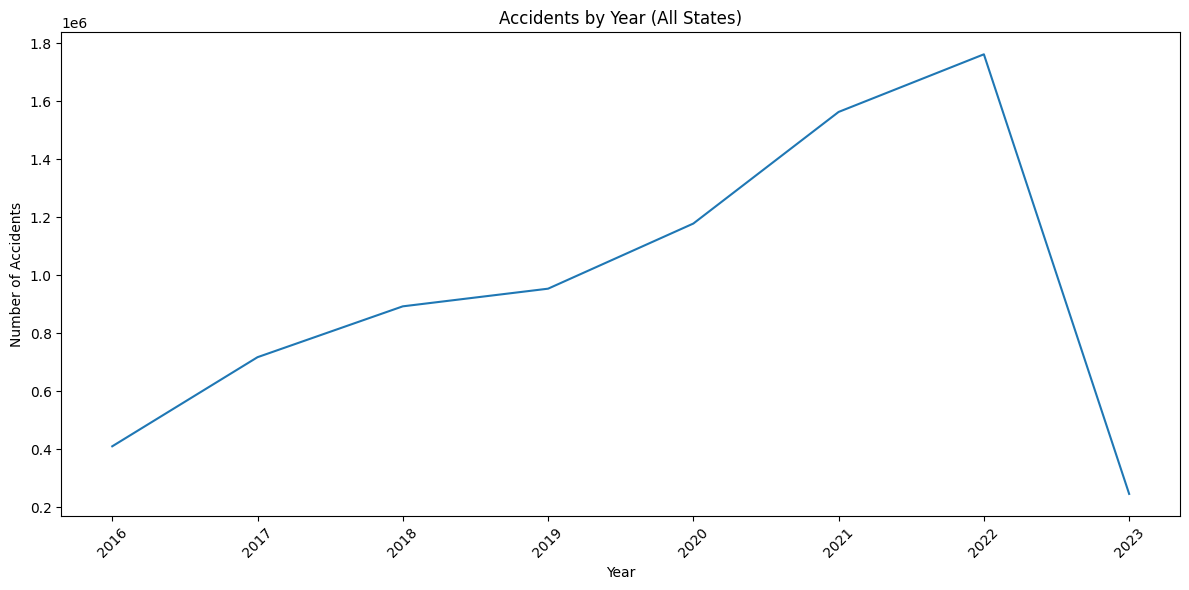

In [39]:
year_df = df.groupBy("Year").count().toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='count', data=year_df)
plt.title('Accidents by Year (All States)')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

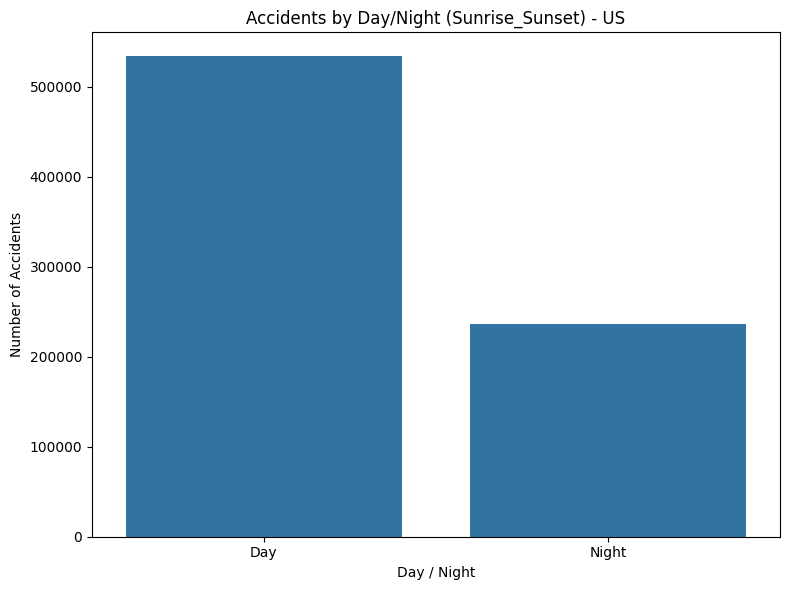

In [41]:
sample_fraction=0.1
top_n_states=5

# Preprocess temporal features
df = df.withColumn("Hour", F.hour("Start_Time")) \
        .withColumn(
            "Severe_Accident",
            F.when(F.col("Severity").isin([3, 4]), 1).otherwise(0)
        )

# Define twilight columns
twilight_cols = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

# Drop rows with null values in relevant columns
df = df.dropna(subset=twilight_cols + ['Hour', 'State', 'Severity'])

# Sample data to reduce memory usage
sample_df = df.sample(fraction=sample_fraction).toPandas()

# Identify top N states by accident count
top_states = sample_df['State'].value_counts().head(top_n_states).index.tolist()

# Plot 1: Distribution of accidents by Sunrise_Sunset
plt.figure(figsize=(8, 6))
sns.countplot(x='Sunrise_Sunset', data=sample_df)
plt.title('Accidents by Day/Night (Sunrise_Sunset) - US')
plt.xlabel('Day / Night')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

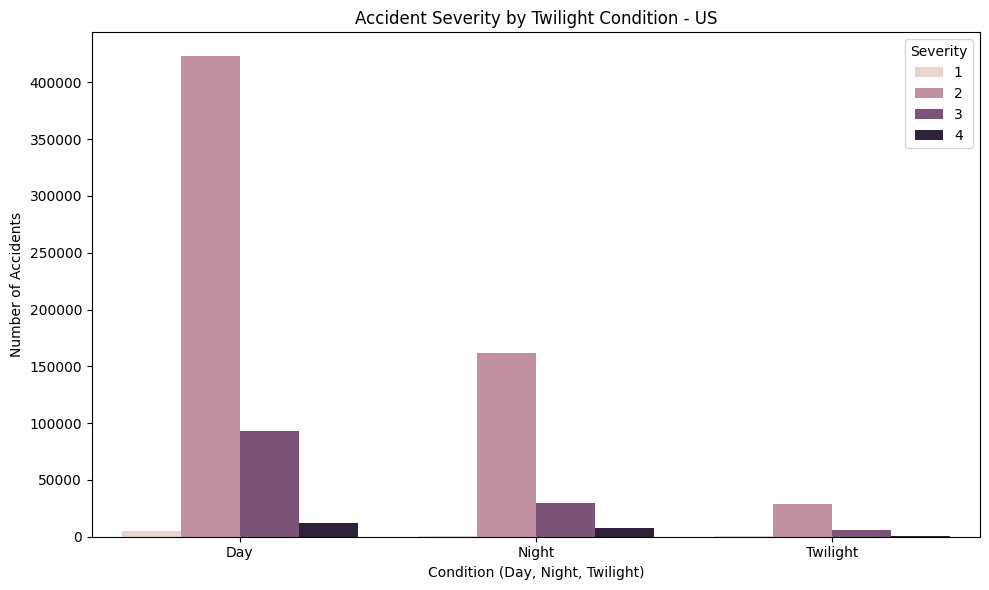

In [42]:
# Plot 2: Severity by Twilight Condition
sample_df['Twilight_Condition'] = sample_df.apply(
    lambda row: 'Twilight' if (
        (row['Sunrise_Sunset'] == 'Day' and row['Civil_Twilight'] == 'Night') or
        (row['Sunrise_Sunset'] == 'Night' and row['Civil_Twilight'] == 'Day')
    ) else row['Sunrise_Sunset'],  # Corrected typo
    axis=1
)
plt.figure(figsize=(10, 6))
sns.countplot(x='Twilight_Condition', hue='Severity', data=sample_df, order=['Day', 'Night', 'Twilight'])
plt.title('Accident Severity by Twilight Condition - US')
plt.xlabel('Condition (Day, Night, Twilight)')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

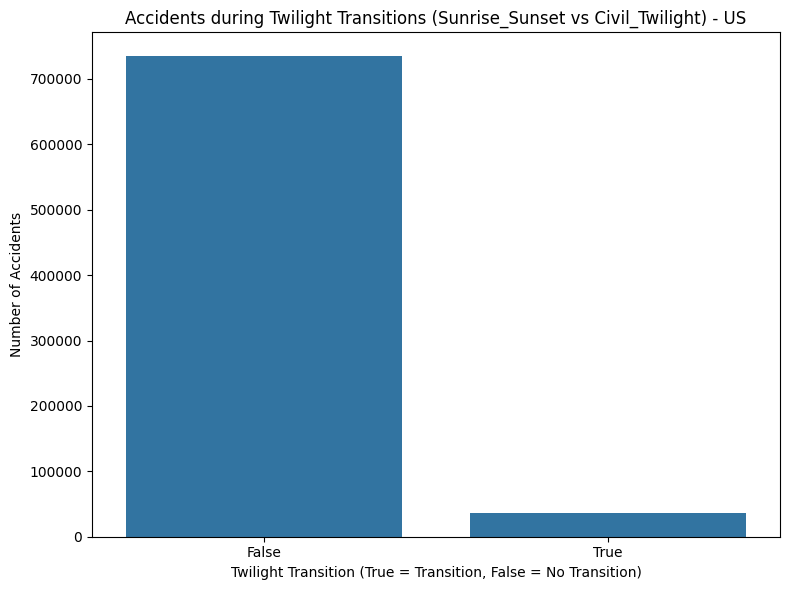

In [43]:
# Plot 3: Accidents during twilight transitions
sample_df['Twilight_Transition'] = (
    (sample_df['Sunrise_Sunset'] == 'Day') & (sample_df['Civil_Twilight'] == 'Night')
) | (
    (sample_df['Sunrise_Sunset'] == 'Night') & (sample_df['Civil_Twilight'] == 'Day')
)
plt.figure(figsize=(8, 6))
sns.countplot(x='Twilight_Transition', data=sample_df)
plt.title('Accidents during Twilight Transitions (Sunrise_Sunset vs Civil_Twilight) - US')
plt.xlabel('Twilight Transition (True = Transition, False = No Transition)')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()


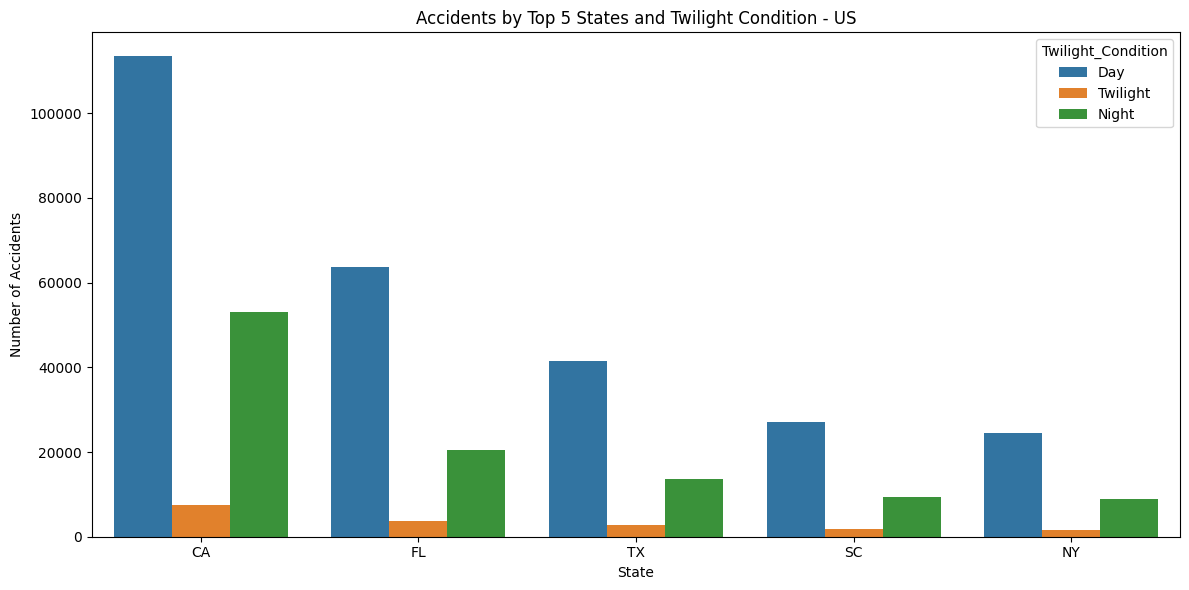

In [44]:

# Plot 4: Accidents by Top States and Twilight Condition
state_df = sample_df[sample_df['State'].isin(top_states)]
plt.figure(figsize=(12, 6))
sns.countplot(x='State', hue='Twilight_Condition', data=state_df, order=top_states)
plt.title(f'Accidents by Top {top_n_states} States and Twilight Condition - US')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()


In [45]:
# Statistical Summary: Accident counts and severity by Twilight Condition
twilight_summary = sample_df.groupby('Twilight_Condition').agg({
    'Severity': ['count', 'mean'],
    'Severe_Accident': 'mean',
    'Hour': 'mean'
}).reset_index()
twilight_summary.columns = ['Twilight_Condition', 'Accident_Count', 'Avg_Severity', 
                            'Prop_Severe_Accidents', 'Avg_Hour']
twilight_summary['Prop_Severe_Accidents'] = twilight_summary['Prop_Severe_Accidents'] * 100  # Convert to percentage

print("Statistical Summary by Twilight Condition (US):")
print(twilight_summary)

# State-Level Summary: Accident counts and severe accidents by top states and Twilight Condition
state_summary = sample_df[sample_df['State'].isin(top_states)].groupby(['State', 'Twilight_Condition']).agg({
    'Severity': ['count', 'mean'],
    'Severe_Accident': 'mean'
}).reset_index()
state_summary.columns = ['State', 'Twilight_Condition', 'Accident_Count', 'Avg_Severity', 'Prop_Severe_Accidents']
state_summary['Prop_Severe_Accidents'] = state_summary['Prop_Severe_Accidents'] * 100  # Convert to percentage

print(f"\nStatistical Summary by Top {top_n_states} States and Twilight Condition (US):")
print(state_summary)

Statistical Summary by Twilight Condition (US):
  Twilight_Condition  Accident_Count  Avg_Severity  Prop_Severe_Accidents  \
0                Day          533949      2.210249              19.770989   
1              Night          200542      2.218707              18.642479   
2           Twilight           36074      2.212896              19.762156   

    Avg_Hour  
0  12.335809  
1  12.548932  
2  11.220491  

Statistical Summary by Top 5 States and Twilight Condition (US):
   State Twilight_Condition  Accident_Count  Avg_Severity  \
0     CA                Day          113403      2.166962   
1     CA              Night           53096      2.163289   
2     CA           Twilight            7443      2.153701   
3     FL                Day           63773      2.134697   
4     FL              Night           20414      2.157245   
5     FL           Twilight            3619      2.165239   
6     NY                Day           24474      2.249530   
7     NY              Night  

Maximum accidents on weekday: Hour 7 with 546372 accidents
Maximum accidents on weekend: Hour 14 with 79918 accidents


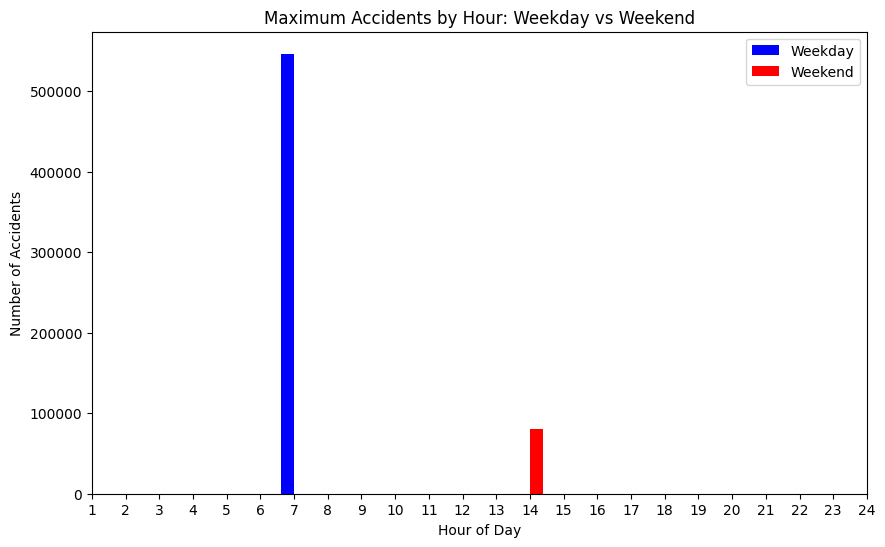

In [46]:
# Group by Hour and Is_Weekend, then count accidents
accidents_by_hour = df.groupBy("Hour", "Is_Weekend").count()

# Find the maximum accidents by weekend and weekday
max_accidents_weekday = accidents_by_hour.filter(F.col("Is_Weekend") == 0).orderBy(F.col("count"), ascending=False).first()
max_accidents_weekend = accidents_by_hour.filter(F.col("Is_Weekend") == 1).orderBy(F.col("count"), ascending=False).first()

# Show results
print(f"Maximum accidents on weekday: Hour {max_accidents_weekday['Hour']} with {max_accidents_weekday['count']} accidents")
print(f"Maximum accidents on weekend: Hour {max_accidents_weekend['Hour']} with {max_accidents_weekend['count']} accidents")

weekday_data = [
    {"Hour": max_accidents_weekday["Hour"], "Count": max_accidents_weekday["count"]},
]
weekend_data = [
    {"Hour": max_accidents_weekend["Hour"], "Count": max_accidents_weekend["count"]},
]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Weekday data
ax.bar(weekday_data[0]["Hour"] - 0.2, weekday_data[0]["Count"], width=0.4, label="Weekday", color="blue")

# Weekend data
ax.bar(weekend_data[0]["Hour"] + 0.2, weekend_data[0]["Count"], width=0.4, label="Weekend", color="red")

# Labels and title
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Number of Accidents")
ax.set_title("Maximum Accidents by Hour: Weekday vs Weekend")
ax.legend()

# Display the plot
plt.xticks(range(1, 25))  # Show hours from 1 to 24
plt.show()


### **Time Analysis Insights**

1. **Winter and Fall** experience more accidents due to hazardous weather, such as snow, ice, and reduced daylight.
2. **Spring and Summer** see fewer accidents, with **June** being the safest month.
3. **Rush hours** (7-9 AM and 3-6 PM) have the highest accident frequency due to increased traffic.
4. **Late-night hours** (around 2 AM) show the lowest accident frequency.
5. **Weekdays** have more accidents than weekends, with **Friday** being the peak day.
6. **December, January, and November** are the most accident-prone months, likely influenced by winter and holiday factors.
7. Accident counts **steadily grew** from 2016 to 2022, nearly quadrupling in this period, indicating an increase in accident frequency.
8. The **sharp drop in 2023 accident counts** is likely due to incomplete data (up to March), not a true decline.